In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from tqdm import tqdm
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU
)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [ ]:
IMG_SIZE = 128
BASE_DIR = '/content/drive/MyDrive/CattleImageRepository'

def load_and_preprocess_data(base_dir, subdirs):
    X, y = [], []

    x_dirs = ['X', 'x1_files', 'x2_files', 'x3_files', 'x4_files', 'X']
    y_dirs = ['Y', 'y1_files', 'y2_files', 'y3_files', 'y4_files', 'y']

    for subdir in subdirs:

        counter = 0

        full_path = os.path.join(base_dir, *subdir.split('/'))

        x_dir, y_dir = None, None

        for x_subdir, y_subdir in zip(x_dirs, y_dirs):
            test_x_dir = os.path.join(full_path, x_subdir)
            test_y_dir = os.path.join(full_path, y_subdir)
            if os.path.isdir(test_x_dir) and os.path.isdir(test_y_dir):
                x_dir, y_dir = test_x_dir, test_y_dir
                break

        if x_dir and y_dir:
            x_files = [f for f in os.listdir(x_dir) if f.endswith(('x.png', 'x1.png', 'x.jpeg', 'x1.jpeg'))]

            for x_file in x_files:
                y_file = x_file.replace('x.', 'y.').replace('x1.', 'y1.')
                y_path = os.path.join(y_dir, y_file)
                if os.path.exists(y_path):
                    x_path = os.path.join(x_dir, x_file)
                    img = cv2.imread(x_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    X.append(img)

                    mask = cv2.imread(y_path)
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                    y.append(mask)

                    counter += 1

            print(f"{subdir}: {counter} imagens processadas.")
        else:
            print(f"Erro: Pastas 'X' ou 'Y/y' não encontradas em {subdir}")

    return np.array(X), np.array(y)

subdirs = [
    'G1/01-08-2024', 'G1/08-08-2024',
    'G2/29-07/00000000196000500', 'G2/29-07/00000000196000400',
    'G2/06-08/Video_1', 'G2/06-08/Video_2',
    'G3/30-07/termica', 'G4/02-08'
]

X, y = load_and_preprocess_data(BASE_DIR, subdirs)
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

G1/01-08-2024: 580 imagens processadas.
G1/08-08-2024: 137 imagens processadas.
G2/29-07/00000000196000500: 218 imagens processadas.
G2/29-07/00000000196000400: 268 imagens processadas.
G2/06-08/Video_1: 771 imagens processadas.
G2/06-08/Video_2: 63 imagens processadas.
G3/30-07/termica: 607 imagens processadas.
G4/02-08: 830 imagens processadas.


(128, 128, 3)


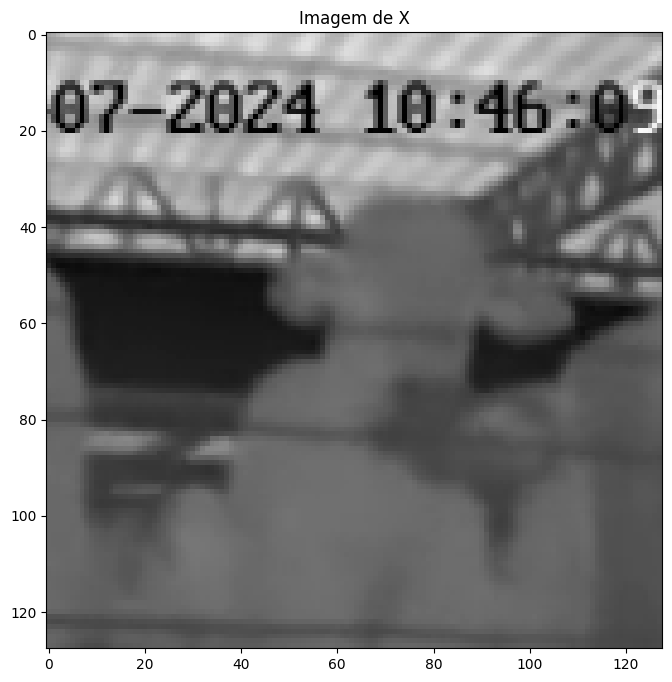

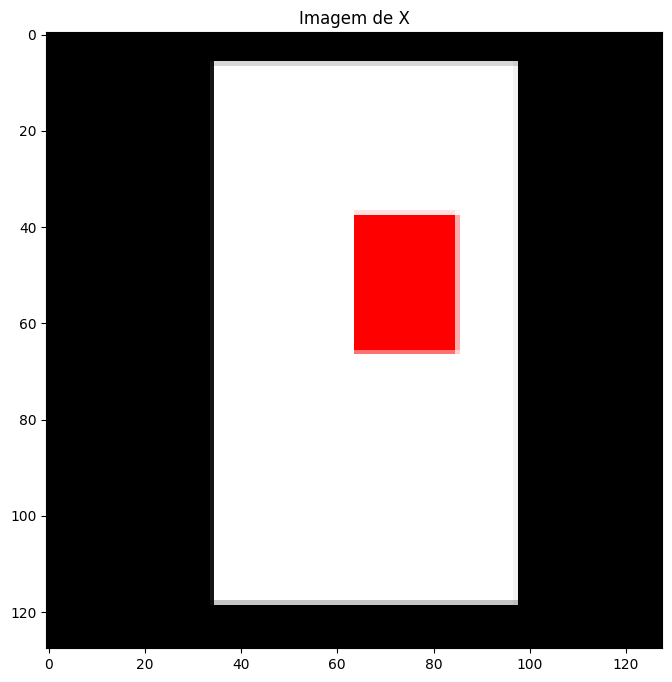

In [ ]:
image = X[np.random.randint(0, X.shape[0])]
image2= y[np.random.randint(0, y.shape[0])]

if image.shape[-1] == 1:
    image = image.squeeze()

if image2.shape[-1] == 1:
    image2 = image2.squeeze()

print(image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Imagem de X')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Imagem de X')
plt.show()

In [ ]:
X.shape, y.shape

((3474, 128, 128, 3, 1), (3474, 128, 128, 3, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [ ]:
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (2779, 128, 128, 3, 1)
Shape de X_test: (695, 128, 128, 3, 1)
Shape de y_train: (2779, 128, 128, 3, 1)
Shape de y_test: (695, 128, 128, 3, 1)


In [ ]:
def apply_data_augmentation(X, y, variations=2):

    X_augmented = []
    y_augmented = []

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    for i in range(X.shape[0]):

        image = X[i]
        mask = y[i]

        if image.ndim == 4:
            image = image.squeeze()
        if mask.ndim == 4:
            mask = mask.squeeze()

        X_augmented.append(image)
        y_augmented.append(mask)

        for j in range(variations):
            params = datagen.get_random_transform(image.shape)

            augmented_image = datagen.apply_transform(image, params)
            augmented_mask = datagen.apply_transform(mask, params)

            X_augmented.append(augmented_image)
            y_augmented.append(augmented_mask)

    return np.array(X_augmented), np.array(y_augmented)

X_train_augmented, y_train_augmented = apply_data_augmentation(X_train, y_train)

In [ ]:
X_train_augmented = X_train_augmented / 255.0
y_train_augmented = y_train_augmented / 255.0

X_test = X_test / 255.0
y_test = y_test / 255.0

In [ ]:
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [ ]:
X_train_augmented.shape, y_train_augmented.shape

((8337, 128, 128, 3), (8337, 128, 128, 3))

In [ ]:
X_test.shape, y_test.shape

((695, 128, 128, 3), (695, 128, 128, 3))

(-0.5, 127.5, 127.5, -0.5)

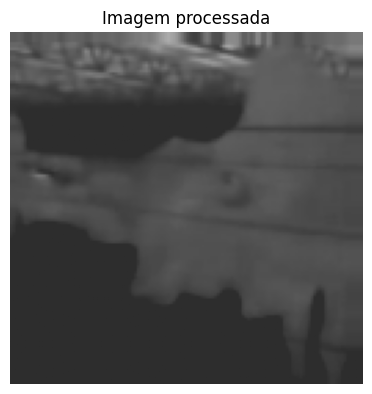

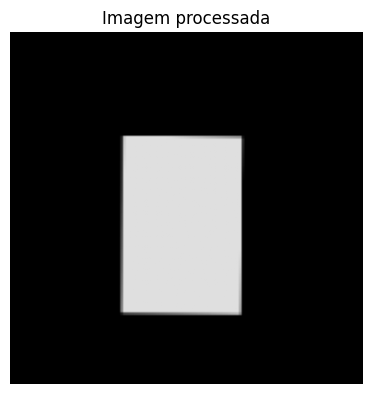

In [ ]:
index = np.random.randint(0, X_train_augmented.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

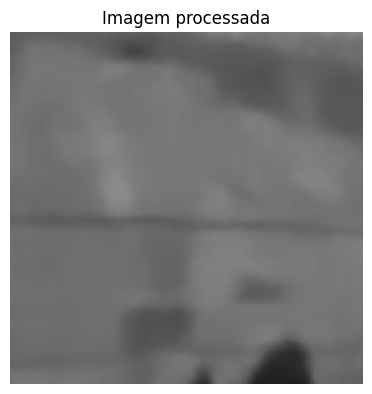

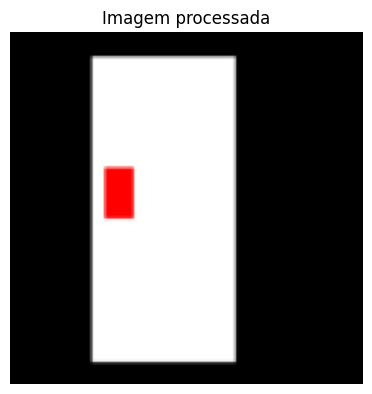

In [ ]:
index = np.random.randint(0, X_test.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_test[index])
plt.title("Imagem processada")
plt.axis('off')

In [ ]:
def reduce_colors(img_array, colors):
    assert img_array.shape == (128, 128, 3), "Input array must have shape (128, 128, 3)"
    fixed_colors = np.array(colors)
    pixels = img_array.reshape(-1, 3)
    distances = np.sqrt(((pixels[:, np.newaxis, :] - fixed_colors) ** 2).sum(axis=2))
    nearest_color_indices = distances.argmin(axis=1)
    new_img = fixed_colors[nearest_color_indices].reshape(img_array.shape)
    return (new_img * 255).astype('uint8')

def reduce_colors_dataset(dataset, colors):
    return np.array([reduce_colors(img, colors) for img in tqdm(dataset, desc="Processing images")])

In [ ]:
colors = [
    (1.0, 1.0, 1.0),  # White
    (1.0, 0.0, 0.0),  # Red
    (0.0, 0.0, 0.0)   # Black
]

y_train_reduced = reduce_colors_dataset(y_train_augmented, colors)
y_test_reduced = reduce_colors_dataset(y_test, colors)

Processing images: 100%|██████████| 695/695 [00:01<00:00, 400.73it/s]


In [ ]:
X_train_augmented.shape

(8337, 128, 128, 3)

In [ ]:
y_train_reduced.shape

(8337, 128, 128, 3)

In [ ]:
def process_images(X_train, X_test):

    def apply_clahe(image):
        image_gray = (image * 255).astype(np.uint8)
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(2, 2))
        image_clahe = clahe.apply(image_gray)
        image_clahe_rgb = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        return image_clahe_rgb / 255.0

    def adjust_contrast(image, factor):
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        enhancer = ImageEnhance.Contrast(image_pil)
        image_pil = enhancer.enhance(factor)
        return np.array(image_pil) / 255.0

    def process_single_image(image):
        clahe_image = apply_clahe(image)
        adjusted_image = adjust_contrast(clahe_image, 1.5)
        return adjusted_image

    X_train_processed = np.array([process_single_image(img) for img in X_train])
    X_test_processed = np.array([process_single_image(img) for img in X_test])

    return X_train_processed, X_test_processed

In [ ]:
X_train_processed, X_test_processed = process_images(X_train_augmented.copy(), X_test.copy())

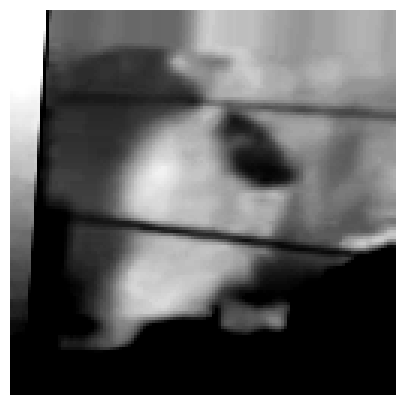

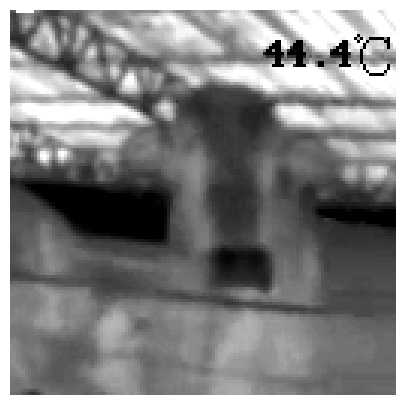

In [ ]:
index_random = np.random.randint(0, X_test_processed.shape[0])

plt.figure(figsize=(10, 5))
plt.imshow(X_train_processed[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

plt.figure(figsize=(10, 5))
plt.imshow(X_test_processed[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

In [ ]:
X_train, y_train = X_train_processed, y_train_reduced
X_test, y_test = X_test_processed, y_test_reduced

In [ ]:
val_split = 0.2
val_samples = int(len(X_train) * val_split)
X_train_vgg16, y_train_vgg16 = X_train[:-val_samples], y_train[:-val_samples]
X_val_vgg16, y_val_vgg16 = X_train[-val_samples:], y_train[-val_samples:]

In [ ]:
def preprocess_y(y):

    black = [0, 0, 0]
    white = [255, 255, 255]
    red = [255, 0, 0]

    mask_black = np.all(y == black, axis=-1)
    mask_white = np.all(y == white, axis=-1)
    mask_red = np.all(y == red, axis=-1)

    y_processed = np.stack([mask_black, mask_white, mask_red], axis=-1).astype(np.float32)

    return y_processed

y_train_processed = preprocess_y(y_train_vgg16)
y_val_processed = preprocess_y(y_val_vgg16)

print("Forma de y_train_processed:", y_train_processed.shape)
print("Forma de y_val_processed:", y_val_processed.shape)

assert np.allclose(np.sum(y_train_processed, axis=-1), 1.0)
assert np.allclose(np.sum(y_val_processed, axis=-1), 1.0)

y_train_processed = tf.convert_to_tensor(y_train_processed)
y_val_processed = tf.convert_to_tensor(y_val_processed)

Forma de y_train_processed: (6670, 128, 128, 3)
Forma de y_val_processed: (1667, 128, 128, 3)


In [ ]:
y_test_processed = preprocess_y(y_test)
y_test_processed = tf.convert_to_tensor(y_test_processed)

In [ ]:
y_train_processed.shape

TensorShape([6670, 128, 128, 3])

In [ ]:
tf.random.set_seed(56)

vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

output_ = vgg16_base.output

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']:
        layer.trainable = False

vgg_model = Model(inputs=vgg16_base.input, outputs=output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

vgg_model.summary()

K.clear_session()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def three_class_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        class_weights = 1.0 / (K.sum(K.sum(y_true, axis=[1, 2]), axis=0) + epsilon)
        class_weights = class_weights / K.sum(class_weights)
        class_weights = K.expand_dims(K.expand_dims(K.expand_dims(class_weights, axis=0), axis=0), axis=0)

        ce_loss = categorical_crossentropy(y_true, y_pred)
        pt = K.sum(y_true * y_pred, axis=-1)
        focal_loss = alpha * K.pow(1. - pt, gamma) * ce_loss

        weighted_focal_loss = K.sum(class_weights * y_true, axis=-1) * focal_loss

        return K.mean(weighted_focal_loss)
    return loss

def ModelEnhancer():
    input_shape = (128, 128, 3)
    VGG16_weight = vgg_model.get_weights()
    vgg_base = VGG16(include_top=False, weights=None, input_shape=input_shape)
    vgg_base.set_weights(VGG16_weight)
    last_layer = vgg_base.output

    set_trainable = False
    for layer in vgg_base.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']:
            layer.trainable = False

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block5_output = vgg_base.get_layer("block5_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block5_output)[1:3]:
        block5_output = Cropping2D(cropping=((1, 1), (1, 1)))(block5_output)
    concat_1 = concatenate([model_, block5_output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block4_output = vgg_base.get_layer("block4_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block4_output)[1:3]:
        block4_output = Cropping2D(cropping=((1, 1), (1, 1)))(block4_output)
    concat_2 = concatenate([model_, block4_output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block3_output = vgg_base.get_layer("block3_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block3_output)[1:3]:
        block3_output = Cropping2D(cropping=((1, 1), (1, 1)))(block3_output)
    concat_3 = concatenate([model_, block3_output])

    model_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block2_output = vgg_base.get_layer("block2_conv2").output
    if K.int_shape(model_)[1:3] != K.int_shape(block2_output)[1:3]:
        block2_output = Cropping2D(cropping=((1, 1), (1, 1)))(block2_output)
    concat_4 = concatenate([model_, block2_output])

    model_ = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block1_output = vgg_base.get_layer("block1_conv2").output
    if K.int_shape(model_)[1:3] != K.int_shape(block1_output)[1:3]:
        block1_output = Cropping2D(cropping=((1, 1), (1, 1)))(block1_output)
    concat_5 = concatenate([model_, block1_output])

    model_ = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (3, 3), strides=(1, 1), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (1, 1), activation='softmax', padding='same')(model_)

    model_ = Model(vgg_base.input, model_)

    return model_

model = ModelEnhancer()
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=three_class_focal_loss(),
              metrics=[CategoricalAccuracy(), MeanIoU(num_classes=3)])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_three_class_model.keras', save_best_only=True, monitor='val_mean_io_u')

history = model.fit(
    X_train_vgg16, y_train_processed,
    validation_data=(X_val_vgg16, y_val_processed),
    epochs=6,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    batch_size=32
)

Epoch 1/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - categorical_accuracy: 0.5017 - loss: 0.0035 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.7747 - val_loss: 0.0021 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - categorical_accuracy: 0.7894 - loss: 0.0020 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.7969 - val_loss: 0.0017 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 3/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - categorical_accuracy: 0.8320 - loss: 0.0016 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.8454 - val_loss: 0.0016 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 4/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - categorical_accuracy: 0.8528 - loss: 0.0013 - mean_io_u_5: 0.2590 - val_categorical_accuracy: 0.8478 - val_loss: 0.0014 - val_mean_io_u_5: 0.2500 - learning_rate: 1.0000e-04
Epoch 5/6
209/209 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - categorical_accuracy: 0.8676

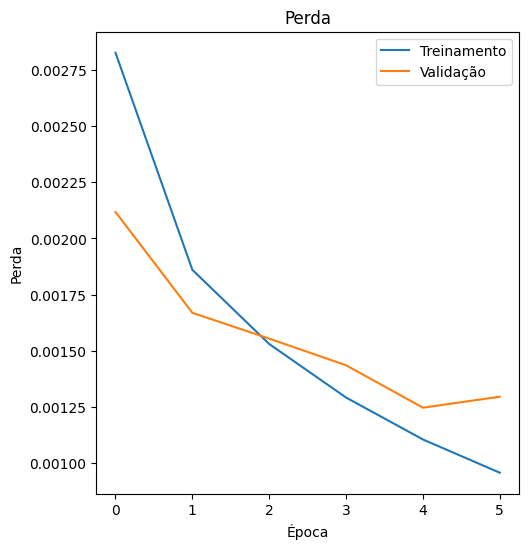

In [ ]:
history_dict = history.history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


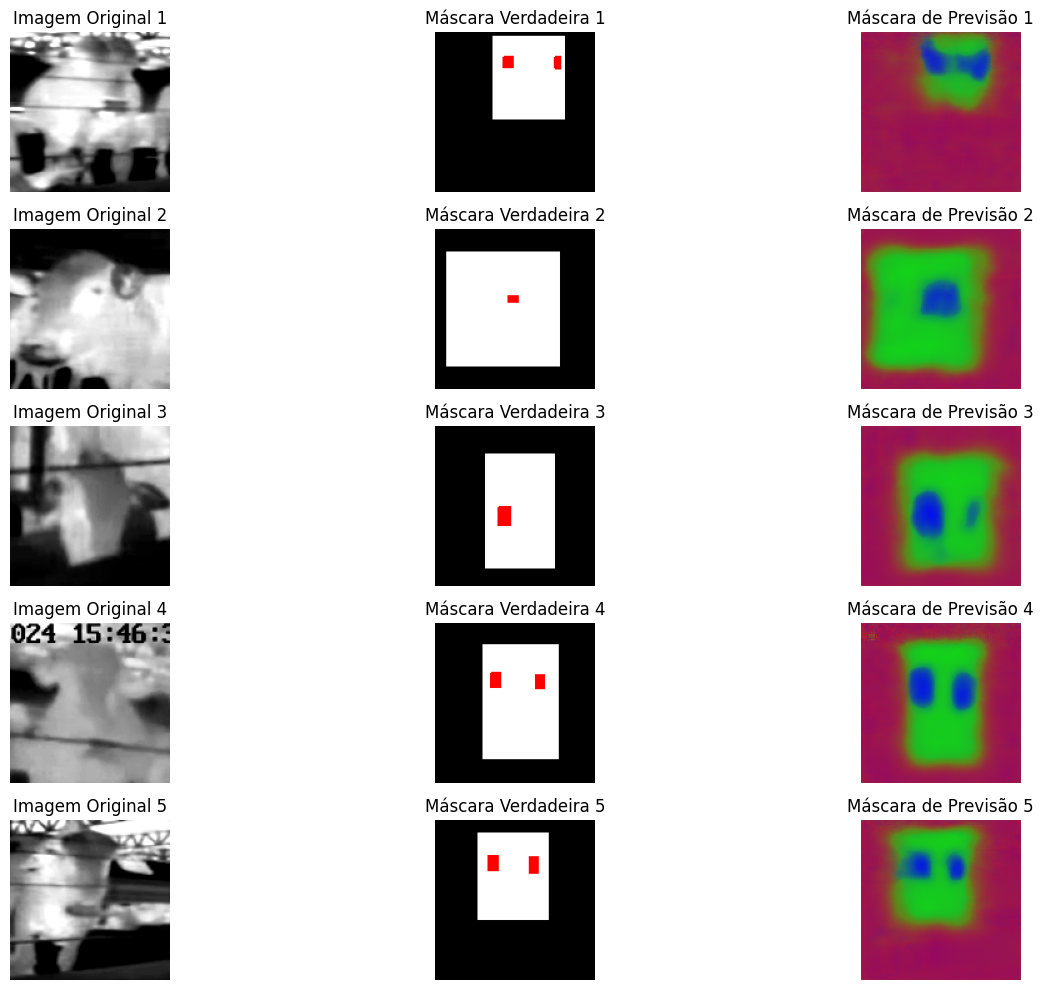

In [ ]:
predictions = model.predict(X_test)

num_images_to_show = 5

plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(num_images_to_show, 3, i * 3 + 1)
    plt.title(f"Imagem Original {i+1}")
    plt.imshow(X_test[i].reshape(X_test.shape[1:]), cmap='gray')
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 2)
    plt.title(f"Máscara Verdadeira {i+1}")
    plt.imshow(y_test[i].reshape(y_test.shape[1:]), cmap='gray')
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 3)
    plt.title(f"Máscara de Previsão {i+1}")
    plt.imshow(predictions[i].reshape(predictions.shape[1:]), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save('VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5')
files.download('VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

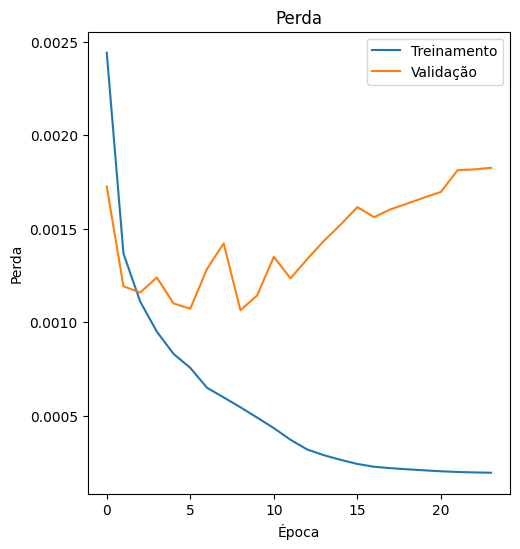

In [ ]:
history_dict = history.history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()